52 / 11605  inliers/matched


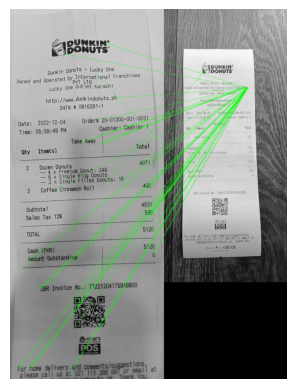

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

def filter_matches(kp1, kp2, matches, ratio=1):
    # Ratio test to filter good matches
    mkp1, mkp2, good = [], [], []
    for m in matches:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            m = m[0]
            mkp1.append(kp1[m.queryIdx])
            mkp2.append(kp2[m.trainIdx])
            good.append(m)
    p1 = np.float32([kp.pt for kp in mkp1])
    p2 = np.float32([kp.pt for kp in mkp2])
    kp_pairs = zip(mkp1, mkp2)
    print('kp pairs into work',kp_pairs)
    return p1, p2, kp_pairs, good

def explore_match(img1, img2, kp1, kp2, good, status=None, H=None):
    # Draw homography and lines between matches
    h1, w1 = img1.shape[:2]
    if status is not None:
        matchesMask = status.ravel().tolist()
    else:
        matchesMask = None

    pts = np.float32([[0, 0], [0, h1 - 1], [w1 - 1, h1 - 1], [w1 - 1, 0]]).reshape(-1, 1, 2)
    if H is not None:
        dst = cv.perspectiveTransform(pts, H)
        img2new = cv.polylines(img2, [np.int32(dst)], True, 255, 3, cv.LINE_AA)
    else:
        img2new = img2

    draw_params = dict(matchColor=(0, 255, 0),  # Draw matches in green color
                       singlePointColor=None,
                       matchesMask=matchesMask,  # Draw only inliers
                       flags=2)

    img3 = cv.drawMatches(img1, kp1, img2new, kp2, good, None, **draw_params)
    return img3

# path of image 1
path1 = "/home/gaditek/Receipt-Scanner/CustomerDataset/Hardee's/Lucky-One-Mall/37552-63c6d4f0e5fb5.png"

# path of image 2
path2 = "/home/gaditek/Receipt-Scanner/ReceiptDataset/Hardee's/hardees-lucky-one-mall-karachi/3l5Uu3DMQiWrN4OothC9daREJf9ArabmVU6jJyMV.jpg"
img1 = cv.imread(path1,0)
img2 = cv.imread(path2,0)


# Create BRISK detector
brisk = cv.BRISK_create()

# Finding keypoints and descriptors
kp1, desc1 = brisk.detectAndCompute(img1, None)
kp2, desc2 = brisk.detectAndCompute(img2, None)

# Create FLANN based matcher
FLANN_INDEX_LSH = 6
flann_params = dict(algorithm=FLANN_INDEX_LSH,
                    table_number=6,  # 12
                    key_size=12,     # 20
                    multi_probe_level=1)  # 2
matcher = cv.FlannBasedMatcher(flann_params, {})

# Finding raw matches
raw_matches = matcher.knnMatch(desc1, trainDescriptors=desc2, k=2)

# Filtering good matches
p1, p2, kp_pairs, good = filter_matches(kp1, kp2, raw_matches)

if len(p1) >= 1:
    # Estimate homography using RANSAC
    H, status = cv.findHomography(p1, p2, cv.RANSAC, 5.0)
    # inlier_percentage = np.sum(status) / len(status) * 100
    print('%d / %d  inliers/matched' % (np.sum(status), len(status)))
    # print('%.2f%% of keypoints matched are inliers' % inlier_percentage)
else:
    H, status = None, None
    print('%d matches found, not enough for homography estimation' % len(p1))

# Visualize matches
vis = explore_match(img1, img2, kp1, kp2, good, status, H)

# Display the result
plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
